In [1]:
import sys
sys.path.insert(0, "../")
import rebound
import numpy as np
from src.utilities.particle_production import EjectionVector
from src.utilities.constants import sec2year, rad2Deg, m2au, au2m
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
sim = rebound.Simulation('/Users/bethclark/Projects/Flora_Family/data/sim_inits/Flora_Init_1.bin')
sim.remove(hash='Mercury')
# sim.remove(hash="Venus")
# sim.remove(hash="Earth")
# sim.remove(hash="Mars")
# sim.remove(hash="Jupiter")
# sim.remove(hash="Saturn")
# sim.remove(hash="Neptune")
# sim.remove(hash="Uranus")
sim.move_to_hel()
ps = sim.particles
# sim.integrator
sim.dt = int(1e6)

In [3]:
flora = ps["Flora"]

eject_vectors = [EjectionVector(100) for i in range(18)]
x, y, z = flora.xyz
vx, vy, vz = flora.vxyz
for V in eject_vectors:
    sim.add(x=x, y=y, z=z,vx=vx+V[0], vy=vy+V[1], vz=vz+V[2], r = 5000)

sim.remove(hash="Flora")
[p.calculate_orbit(ps["Sun"]).a*m2au for p in ps[8:]]

[2.1955474939335704,
 2.1976312817830723,
 2.1845826595829423,
 2.1850376432829273,
 2.1958750123186515,
 2.1944798903966762,
 2.1897146674959034,
 2.2207815420787917,
 2.2019775421400647,
 2.2144751822744992,
 2.2106034996136517,
 2.216156918684634,
 2.217095024110849,
 2.1873698789150255,
 2.191228295517407,
 2.1954532276157646,
 2.2074655369777267,
 2.1821520801053995]

In [4]:
sim2 = rebound.Simulation()
sim2.units = ("m", "kg", 's')
sim2.integrator = "WHFast"
sim2.dt = 1e6
for p in ps:
    sim2.add(p)
sim2.status()

---------------------------------
REBOUND version:     	3.17.2
REBOUND built on:    	Jun  7 2021 17:27:05
Number of particles: 	26
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	1000000.000000
---------------------------------
<rebound.particle.Particle object at 0x7fd7fadde2c0, m=1.988475415966536e+30 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fd7fadde4c0, m=4.86746636068329e+24 x=41915483147.63281 y=103570898463.67188 z=-1150525082.4936523 vx=-31661.90342454766 vy=12101.26573965562 vz=278.17611266047146>
<rebound.particle.Particle object at 0x7fd7fadde2c0, m=6.04583029776e+24 x=135885160414.03125 y=-64300781790.75 z=-7401999812.92627 vx=13446.752320384177 vy=26362.966327277176 vz=-721.4155452101186>
<rebound.particle.Particle object at 0x7fd7fadde4c0, m=6.41711131209051e+23 x=131371008571.03906 y=178059046286.53125 z=-17412390194.341797 vx=-21155.052940324953 vy=12885.572337886091 vz=-167.8793484504

In [ ]:
archive_path = Path('/Users/bethclark/Projects/Flora_Family/data/sim_archives')
test_name = 'test3.bin'

program_path = "/Users/bethclark/Projects/Flora_Family/src_C/10km_yarko/rebound"

In [6]:
sim2.save((archive_path / test_name).__str__())

In [6]:
import subprocess
result = subprocess.Popen([program_path, archive_path], stdout=subprocess.PIPE)
result.stdout.read()

In [5]:
sa = rebound.SimulationArchive((archive_path / test_name).__str__())

In [6]:
print(len(sa))

sa.tmin/sec2year, sa.tmax/sec2year

201


(0.0, 10000000.0)

In [7]:
sa[2].status()

---------------------------------
REBOUND version:     	3.17.2
REBOUND built on:    	Jun  7 2021 17:27:05
Number of particles: 	26
Selected integrator: 	whfast
Simulation time:     	3.1536000000000000e+12
Current timestep:    	1000000.000000
---------------------------------
<rebound.particle.Particle object at 0x7f9e1eeb64c0, m=1.988475415966536e+30 x=-40916840441776.98 y=-13986797764078.91 z=1351034787525.9229 vx=-27.287553908081932 vy=-11.07718248757274 vz=0.8789536962652927>
<rebound.particle.Particle object at 0x7f9e1eeb65c0, m=4.86746636068329e+24 x=-40995182514963.51 y=-13908911026964.408 z=1352216948398.4465 vx=-24973.44599378176 vy=-23515.290129404715 vz=1152.1812851460097>
<rebound.particle.Particle object at 0x7f9e1eeb64c0, m=6.04583029776e+24 x=-41010600916761.27 y=-14108866084350.238 z=1350737769075.5454 vx=23140.87400260003 vy=-17345.96063502852 vz=158.96545814678228>
<rebound.particle.Particle object at 0x7f9e1eeb65c0, m=6.41711131209051e+23 x=-40988536212539.195 y=-1375

In [8]:
p_as = {}
a0 = []
for i, p in enumerate(sa[0].particles[8:]):
    orb = p.calculate_orbit(sa[0].particles[0])
    p_as[i] =[]
    a0.append(orb.a*m2au)

for i in range(len(sa)):
    sim = sa[i]
    ps = sim.particles
    for j, p in enumerate(ps[8:]):
        orb = p.calculate_orbit(ps[0])
        p_as[j].append(orb.a*m2au - a0[j])

In [25]:
def data_smoother(data, box_size):
    if box_size%2 == 0: # even
        box_size+=1 #dont want even

    if box_size == 1:
        return data

    N = len(data)
    ovr_undr = np.floor(box_size/2)
    b_range = np.arange(-ovr_undr, ovr_undr)

    ret_data = []
    for i in range(N):
        box_data = [data[int(i+r)] for r in b_range if i+r > 0 and i+r<N] # only grab data in range
        ret_data.append(np.mean(box_data))
    return ret_data

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


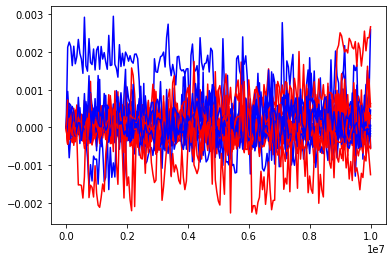

In [26]:
time = [sa[i].t/sec2year for i in range(len(sa))]

for i, key in enumerate(p_as):
    if i%2 == 0:
        data = p_as[key]
        plt.plot(time, data_smoother(data, 0), c='blue')
    if i%2 == 1:
        data = p_as[key]
        plt.plot(time, data_smoother(data, 0), c='red')
# plt.ylim(-.0003, .0003)
plt.show()

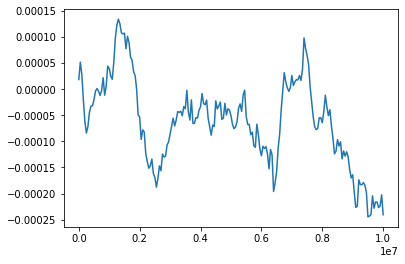

In [20]:
plt.plot(time, data_smoother(p_as[1], 21))